In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('../data-new/train/X_train_imputed.csv')
y_train = pd.read_csv('../data-new/train/y_train.csv')
X_val = pd.read_csv('../data-new/val/X_val_imputed.csv')
y_val = pd.read_csv('../data-new/val/y_val.csv')
X_test = pd.read_csv('../data-new/test/X_test_imputed.csv')
y_test = pd.read_csv('../data-new/test/y_test.csv')

In [3]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))


0.64


c:\Users\andre\workspace\HA-mortality-prediction\venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, weights='uniform', p=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))


0.2222222222222222


c:\Users\andre\workspace\HA-mortality-prediction\venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred))

from sklearn.svm import SVC


0.3333333333333333


c:\Users\andre\workspace\HA-mortality-prediction\venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),  # Single output for binary classification
            nn.Sigmoid()  # Sigmoid for binary classification
        )
        
    def forward(self, x):
        return self.layers(x)

In [29]:
class NeuralNetwork_2(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork_2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )
        
    def forward(self, x):
        return self.layers(x)

In [18]:
def train_neural_network(model, X_train, y_train, X_val, y_val, 
                        epochs=50, batch_size=32, learning_rate=0.001):
    # Convert data to PyTorch tensors and create DataLoader
    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.FloatTensor(y_train.values.ravel())
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Validation data
    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = torch.FloatTensor(y_val.values.ravel())
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training history
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            X_val_tensor = X_val_tensor.to(device)
            y_val_tensor = y_val_tensor.to(device)
            val_outputs = model(X_val_tensor).squeeze()
            val_loss = criterion(val_outputs, y_val_tensor)
            
        # Record losses
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss.item())
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}')
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return model


Epoch [10/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [20/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [30/50], Train Loss: 3.4375, Val Loss: 7.1429
Epoch [40/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [50/50], Train Loss: 3.4635, Val Loss: 7.1429


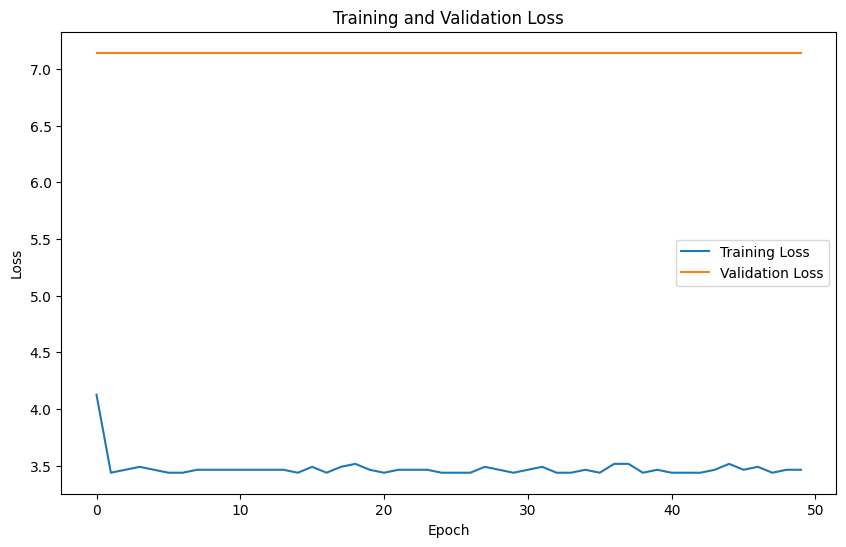

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [19]:
model = NeuralNetwork(input_size=X_train.shape[1], hidden_size=256)  # This creates an instance

train_neural_network(model, X_train, y_train, X_val, y_val)

In [21]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test.values)
    y_test_tensor = torch.FloatTensor(y_test.values.ravel())
    test_outputs = model(X_test_tensor).squeeze()
    test_loss = f1_score(y_test, test_outputs)
    print(f'Test F1: {test_loss.item():.4f}')

Test F1: 0.0000


Epoch [10/50], Train Loss: 3.4896, Val Loss: 7.1429
Epoch [20/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [30/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [40/50], Train Loss: 3.4635, Val Loss: 7.1429
Epoch [50/50], Train Loss: 3.4375, Val Loss: 7.1429


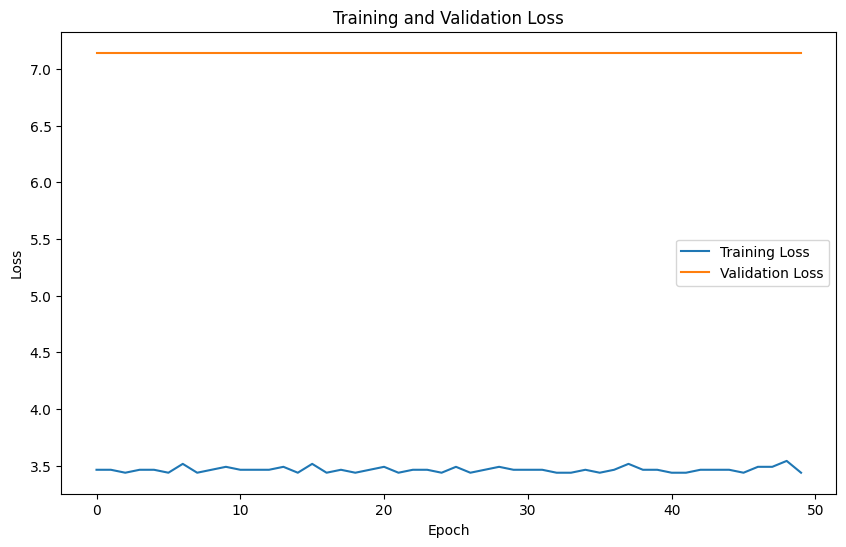

NeuralNetwork_2(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [30]:
model_2 = NeuralNetwork_2(input_size=X_train.shape[1])  # This creates an instance

train_neural_network(model_2, X_train, y_train, X_val, y_val)

In [31]:
model_2.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test.values)
    y_test_tensor = torch.FloatTensor(y_test.values.ravel())
    test_outputs = model_2(X_test_tensor).squeeze()
    test_loss = f1_score(y_test, test_outputs)
    print(f'Test F1: {test_loss.item():.4f}')

Test F1: 0.0000
